In [1]:
import random
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV


%matplotlib inline

# 1. Simple EDA and Baseline Model

In [ ]:
top1000_clean = pd.read_pickle("top1000_oscars.pkl")
top1000_clean.head()

In [ ]:
top1000_clean.shape

In [ ]:
top1000_clean.info()
#3 variables have missing values
#Domestic Open and Budget.
#Domestic Open doesn't make sense to keep though, dropping

In [ ]:
#Going to make a simplified dataframe with only the key features.
smaller_df = top1000_clean.loc[:,['Title', 'Domestic_Gr','Budget', 'Genre',
                                  'Rating', 'Distributor', 'Director', 'MainChar',
                                  'Runtime_tot_mins', 'Years_Since_Release',
                                  'Month_of_Release', 'cumul_freq_direct_r',
                                 'cumul_freq_actor_r', 'star_power']]

In [ ]:
#examining missing data
smaller_df.info()
#two variables with missing data

In [ ]:
corrMatrix = smaller_df.corr()
sns.heatmap(corrMatrix, annot=True);

In [ ]:
sns.pairplot(smaller_df);
#Target variable is skewed to the right / non-normal
#It looks like our target variable is not linearly related to Budget or Runtime
#We can see that the target variable is going to need a transformation due to is non-normality


In [ ]:
smaller_df.corr()

### Setting up for modeling and building **baseline** model...

Need to first dummy code categorical variables.

In [ ]:
#Month_of_Release
smaller_df.Month_of_Release.unique()
#going to categorize by quarters

In [ ]:
smaller_df.groupby(['Month_of_Release']).Domestic_Gr.mean().sort_values(ascending=False)
#Summer winter months seem to be best performing

In [ ]:
value = smaller_df['Month_of_Release']
labels =  smaller_df['Domestic_Gr']
sns.barplot(x=value,y=labels)
plt.show()

In [ ]:
qtrs_dict = {'Jan': 'Q1', "Feb": 'Q1', 'Mar': 'Q1',
            'Apr': 'Q2', 'May': 'Q2', 'Jun': 'Q2',
            'Jul': 'Q3', 'Aug': 'Q3', 'Sep': 'Q3',
            'Oct': 'Q4', 'Nov': 'Q4', 'Dec': 'Q4'}

In [ ]:
smaller_df['CY_Qtr'] = smaller_df['Month_of_Release'].map(qtrs_dict)
smaller_df.head()

In [ ]:
smaller_df.groupby(['CY_Qtr']).Domestic_Gr.median().sort_values(ascending=False)


In [ ]:
value = smaller_df['CY_Qtr']
labels =  smaller_df['Domestic_Gr']
sns.barplot(x=value,y=labels)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [ ]:
#Let's dummy code these now...
qtrs_df = pd.get_dummies(smaller_df.CY_Qtr, drop_first=True)
#Q1 will be the reference

In [ ]:
df_catties = pd.concat([smaller_df, qtrs_df], axis=1)
df_catties.head()

Now, let's address Rating...

In [ ]:
df_catties.info()

In [ ]:
df_catties["Rating"].value_counts()

In [ ]:
df_catties.groupby(['Rating']).Domestic_Gr.median().sort_values(ascending=False)

In [ ]:
value = df_catties['Rating']
labels = df_catties['Domestic_Gr']
sns.barplot(x=value,y=labels)
plt.show()

In [ ]:
ratings_df = pd.get_dummies(df_catties.Rating, drop_first=True)
ratings_df
#G is the reference

In [ ]:
df_catties_rating = pd.concat([df_catties, ratings_df], axis=1)
df_catties_rating.head()

In [ ]:
df_catties_rating.info()

In [ ]:
#need to dummy code Genre....but how???
#let's parse out the FIRST genre listed
df_catties_rating["top_genre"] = df_catties_rating["Genre"].apply(lambda x: x.split(',')[0])
df_catties_rating.head()


In [ ]:
df_catties_rating['top_genre'].value_counts()

In [ ]:
df_catties_rating.groupby(['top_genre']).Domestic_Gr.median().sort_values(ascending=False)


In [ ]:
value = df_catties_rating['top_genre']
labels =  df_catties_rating['Domestic_Gr']
sns.set(rc = {'figure.figsize':(20,8)})
sns.barplot(x=value,y=labels)
plt.show()

In [ ]:
#need to first condense the amount of genres before we dummy code
#condensing Fantasy, Mystery, and Documentary
#genre_dict = {'Action': 'Action', "Adventure": 'Adventure', 'Comedy': 'Comedy',
            #'Drama': 'Drama', 'Biography': 'Biography', 'Horror': 'Horror',
            #'Animation': 'Animation', 'Fantasy': 'AA_Other', 'Mystery': 'AA_Other',
            #'Dcoumentary': 'AA_Other'}

In [ ]:
#df3_catties_2['Genre_r'] = df3_catties_2['top_genre'].map(genre_dict)
#df3_catties_2.head()

In [ ]:
genre_df = pd.get_dummies(df_catties_rating.top_genre, drop_first=True)
genre_df #action is reference

In [ ]:
df_catties_rating_genre = pd.concat([df_catties_rating, genre_df], axis=1)
df_catties_rating_genre.head()

In [ ]:
df_catties_rating_genre

In [ ]:
#last one to dummy code...distributor....
df_catties_rating_genre["Distributor"].value_counts()

In [ ]:
#how many unique value counts in Distributor
df_catties_rating_genre["Distributor"].nunique()

In [ ]:
df_catties_rating_genre.groupby(['Distributor']).Domestic_Gr.median().sort_values(ascending=False)

In [ ]:
#checking out Newmarket Films because that is not familiar to me
df_catties_rating_genre.loc[df_catties_rating_genre['Distributor'] == 'Newmarket Films']
#only 1 movie with this distributor

In [ ]:
#going to retain top 6 most popular grossing movies
distributors = pd.get_dummies(df_catties_rating_genre.Distributor) 
distributors


In [ ]:
distibutors_list = list(distributors.columns)

In [ ]:
top_distributors = ['Warner Bros.','Twentieth Century Fox','Universal Pictures','Walt Disney Studios Motion Pictures',   
                    'Sony Pictures Entertainment (SPE)','Paramount Pictures']

for distributor in distibutors_list:
    if distributor in top_distributors:
        print(distributor)

In [ ]:
#Going to make a simplified dataframe with only the key features.
distributors_r = distributors.loc[:,['Paramount Pictures', 'Sony Pictures Entertainment (SPE)',
                                     'Twentieth Century Fox', 'Universal Pictures',
                                  'Walt Disney Studios Motion Pictures', 'Warner Bros.']]


In [ ]:
distributors_r.head()

In [ ]:
df_catties_rating_genre_distrib = pd.concat([df_catties_rating_genre, distributors_r], axis=1)
df_catties_rating_genre_distrib.head()


In [ ]:
df_catties_rating_genre_distrib.info()

In [ ]:
#checking out all missing values in budget
bool_series = pd.isnull(df_catties_rating_genre_distrib["Budget"])
df_catties_rating_genre_distrib[bool_series]

In [ ]:
#quickdata = df_catties_rating_genre_distrib.drop(columns=['cumul_freq_direct_r', 'cumul_freq_actor_r',
                                                          'CY_Qtr', 'Q2', 'Q3', 'Q4', 'PG',
                                                          'PG-13', 'R', 'top_genre', 'Adventure',
                                                          'Animation', 'Biography', 'Comedy', 'Crime',
                                                          'Documentary', 'Drama', 'Fantasy', 'Horror',
                                                          'Mystery', 'Paramount Pictures', 'Sony Pictures Entertainment (SPE)',
                                                          'Twentieth Century Fox', 'Universal Pictures', 'Walt Disney Studios Motion Pictures',
                                                          'Warner Bros.', 'star_power', 'z_scores_budget',
                                                         'z_scores_target', 'z_scores_Runtime', 'z_scores_Years_Age'])

In [ ]:
#corrMatrix2 = quickdata.corr()
#sns.heatmap(corrMatrix2, annot=True);

In [ ]:
#sns.distplot(quickdata['Domestic_Gr'])
#plt.title('Distribution of Domestic Gross', fontsize=18)
#plt.xlabel('Life Exp (years)', fontsize=16)
#plt.ylabel('Frequency', fontsize=16)

#quickdata['Domestic_Gr'].hist(bins=100)


# BASELINE MODEL

Predictors (numeric): Budget, Runtime_tot_mins, Years_since_release

Predictors (categorical): Genre, Rating, CY Quarter, Distributor

Target: Domestic_Gr

In [ ]:
#going to drop all rows with missing budget for time being
#as this will be an issue in base model
df = df_catties_rating_genre_distrib.dropna(subset=['Budget'])
df.info()

In [ ]:
baselinemodelvars = df.drop(columns=['Title', 'Genre', 'Rating', 'Distributor', 'Month_of_Release',
                                                 'Director', 'MainChar', 'star_power', 'CY_Qtr', 'top_genre', 'cumul_freq_direct_r',
'cumul_freq_actor_r'])
baselinemodelvars.info()


In [ ]:
#going to use CV because a small dataset
#Perform 5-fold cross validation on the data.
#Before doing so, leave 20% of the data as test.
X = df.drop(columns=['Domestic_Gr', 'Title', 'Genre', 'Rating', 'Distributor', 'Month_of_Release',
                                                 'Director', 'MainChar', 'star_power', 'CY_Qtr', 'top_genre', 'cumul_freq_direct_r',
'cumul_freq_actor_r'])

y = df['Domestic_Gr']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

lr = lm.fit(X_train,y_train)

#to see all validation scores
lm_cv = cross_val_score(lm, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv), 3), "+-", np.round(np.std(lm_cv),3))

mean_r2 = np.mean(lm_cv)
std_r2 = np.std(lm_cv)

In [ ]:
#Partition the smaller_df dataset into 60% training, and 20% validation, and 20% test.
#Use 42 as the value for random state. 

#X = df.drop(columns=['Domestic_Gr', 'Title', 'Genre', 'Rating', 'Distributor', 'Month_of_Release',
#'Director', 'MainChar', 'star_power', 'CY_Qtr', 'top_genre', 'cumul_freq_direct_r','cumul_freq_actor_r'])

#y = df['Domestic_Gr']

#X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25,random_state=42)

#Build the Model
#model = LinearRegression()
#lr = model.fit(X_train,y_train)

#r_squared_train = lr.score(X_train, y_train)
#r_squared_val = lr.score(X_val, y_val)

#print(r_squared_train)
#print(r_squared_val)

In [ ]:
# Fitted vs. Actual
y_train_pred = lr.predict(X_train)
plt.title('Fitted vs. Actual', fontsize=35)
plt.scatter(y_train, y_train_pred, alpha=1)
plt.plot([0, 40], [0, 40])

In [ ]:
# Plot Residuals vs. predicted

lin_reg_residuals = y_train - y_train_pred
plt.scatter(y_train_pred, lin_reg_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predictions", fontsize=35)

In [ ]:
#x = df.drop(columns=['Domestic_Gr', 'Title', 'Genre', 'Rating', 'Distributor', 'Month_of_Release', 'Director', 'MainChar', 'star_power', 'CY_Qtr', 'top_genre', 'cumul_freq_direct_r', 'cumul_freq_actor_r'])

#x = sm.add_constant(x)
#y = df['Domestic_Gr']

#model_bl = sm.OLS(y,x, data = df)
#fit_bl = model_bl.fit()
#fit_bl.summary()

In [ ]:
#from scipy import stats
#import matplotlib.pyplot as plt
#predict=fit_bl.predict(x)
#resid=y-predict
# diagnose/inspect residual normality using qqplot:
#stats.probplot(resid, dist="norm", plot=plt)
#plt.title("Normal Q-Q plot")
#plt.show()

# 2. Outlier detection & Imputing missing values
* Imputing missing values for Budget and Rating
* outlier detection

In [ ]:
df_catties_rating_genre_distrib.info()

In [ ]:
sns.boxplot(df_catties_rating_genre_distrib['Domestic_Gr'])
#domestic gross has MANY outliers...

In [ ]:
sns.boxplot(df_catties_rating_genre_distrib['Runtime_tot_mins'])
#many outliers as well

In [ ]:
sns.boxplot(df_catties_rating_genre_distrib['Years_Since_Release'])
#many outliers in Years_since_release

In [ ]:
sns.boxplot(df_catties_rating_genre_distrib['Budget'])
#budget has 5 outliers

In [ ]:
#Creating z scores of all these variables to detect outliers >= 3
df_catties_rating_genre_distrib['z_scores_budget'] = (df_catties_rating_genre_distrib['Budget'] - df_catties_rating_genre_distrib['Budget'].mean())/df_catties_rating_genre_distrib['Budget'].std(ddof=0)

df_catties_rating_genre_distrib['z_scores_target'] = (df_catties_rating_genre_distrib['Domestic_Gr'] - df_catties_rating_genre_distrib['Domestic_Gr'].mean())/df_catties_rating_genre_distrib['Domestic_Gr'].std(ddof=0)

df_catties_rating_genre_distrib['z_scores_Runtime'] = (df_catties_rating_genre_distrib['Runtime_tot_mins'] - df_catties_rating_genre_distrib['Runtime_tot_mins'].mean())/df_catties_rating_genre_distrib['Runtime_tot_mins'].std(ddof=0)

df_catties_rating_genre_distrib['z_scores_Years_Age'] = (df_catties_rating_genre_distrib['Years_Since_Release'] - df_catties_rating_genre_distrib['Years_Since_Release'].mean())/df_catties_rating_genre_distrib['Years_Since_Release'].std(ddof=0)

#df_catties_rating_genre_distrib.loc[df_catties_rating_genre_distrib['z_scores_budget'] > 3]

#19 outliers in our target variable!!!


In [ ]:
#checking out the outliers in the years since release
#13 variables
df_catties_rating_genre_distrib.loc[df_catties_rating_genre_distrib['z_scores_Years_Age'] > 3]


In [ ]:
#let's drop outliers in target variable and see difference in model
df2 = df_catties_rating_genre_distrib[df_catties_rating_genre_distrib.z_scores_target < 3]
df3 = df_catties_rating_genre_distrib[df_catties_rating_genre_distrib.z_scores_budget < 3]
df4 = df_catties_rating_genre_distrib[df_catties_rating_genre_distrib.z_scores_Runtime < 3]
df5 = df_catties_rating_genre_distrib[df_catties_rating_genre_distrib.z_scores_Years_Age < 3]

#df_catties_rating_genre_distrib['Budget'].fillna((df_catties_rating_genre_distrib['Budget'].median()), inplace=True)
#df_catties_rating_genre_distrib.info()

In [ ]:
df5.info()
#still missing values in budget though...

## SECOND MODEL - outlier handling

Predictors (numeric): Budget, Runtime_tot_mins, Years_since_release

Predictors (categorical): Genre, Rating, CY Quarter, Distributor

Target: Domestic_Gr

In [ ]:
#Partition the smaller_df dataset into 60% training, and 20% validation, and 20% test.
#Use 42 as the value for random state. 

#X = df5.drop(columns=['Domestic_Gr', 'Title', 'Genre', 'Rating', 'Distributor', 'Month_of_Release','Director', 'MainChar', 'star_power', 'CY_Qtr', 'top_genre', 'cumul_freq_direct_r','cumul_freq_actor_r', 'z_scores_budget', 'z_scores_target','z_scores_Runtime', 'z_scores_Years_Age'])

#y = df5['Domestic_Gr']



#X, X_test, y, y_test = train_test_split(X, y, test_size=.2,     random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25,   random_state=42)
# Build the Model
#model = LinearRegression()
#lr = model.fit(X_train,y_train)

#r_squared_train = lr.score(X_train, y_train)
#r_squared_val = lr.score(X_val, y_val)

#print(r_squared_train)
#print(r_squared_val)

In [ ]:
#going to pickle COMPLETE FINAL MODEL BUILDING DATA
df_final = df5.dropna(subset=['Budget'])

#going to drop unnecessary variables
df_final = df_final.drop(columns=['z_scores_budget', 'z_scores_target',
                                     'z_scores_Runtime', 'MainChar', 'Director', 'Genre', 'Rating', 'Distributor',
                                  'Month_of_Release', 'z_scores_Years_Age', 'CY_Qtr', 'top_genre', 'star_power'])
df_final.to_pickle("df_final.pkl")

In [2]:
df_final = pd.read_pickle("df_final.pkl")

In [ ]:
df_final.info()

In [ ]:
#going to use CV because a small dataset
#Perform 5-fold cross validation on the data.
#Before doing so, leave 20% of the data as test.
#performing the below code on df2, df3, df4, df5 to see
#which dataset without outliers is best.

X = df_final.drop(columns=['Domestic_Gr', 'Title', 'cumul_freq_direct_r','cumul_freq_actor_r'])

y = df_final['Domestic_Gr']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv = cross_val_score(lm, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv), 3), "+-", np.round(np.std(lm_cv),3))

mean_r2 = np.mean(lm_cv)
std_r2 = np.std(lm_cv)

In [ ]:
#after running the above on df2-df5, df5 gave best average r^2. 
#this means, dropping 13 values with outliers in years since release, ie, age

## MISSING VALUE IMPUTATION in Budget
- Mean imputation didn't improve model
- Median imputation didn't improve model
- Dropping Budget didn't improve model
- Going to leave dataset with missing values dropped as this is best result

In [ ]:
#df5.info()
#now need to handle the missing values in budget for this 996...

In [ ]:
#basic mean and median imputation for Budget at first pass
#df5_mean_impute = df5
#df5_mean_impute['Budget'] = df5_mean_impute['Budget'].fillna(df5_mean_impute['Budget'].mean())

#df5_median_impute = df5
#df5_median_impute['Budget'] = df5_median_impute['Budget'].fillna(df5_median_impute['Budget'].median())

#df5_median_impute.info()


In [ ]:
#X = df5_median_impute.drop(columns=['Domestic_Gr', 'Title', 'Genre', 'Rating', 'Distributor', 'Month_of_Release','Director', 'MainChar', 'star_power', 'CY_Qtr', 'top_genre', 'cumul_freq_direct_r','cumul_freq_actor_r', 'z_scores_budget', 'z_scores_target','z_scores_Runtime', 'z_scores_Years_Age'])

#y = df5_median_impute['Domestic_Gr']

#X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                      # test_size=.2,     
                                       #random_state=42)
#lm = LinearRegression() 

#kf = KFold(n_splits=5, # number of folds
     #shuffle=True, # randomizes order of rows before split
     #random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
#lm_cv = cross_val_score(lm, X_train, y_train, # estimator, features, target
     #cv= kf, # folds created above; could also just use a number 
     #scoring='r2') # scoring metric
#print('Simple regression scores: ', lm_cv)

# to print the mean score with standard deviation, rounded to 2 decimals
#print('Simple mean cv r^2: ', np.round(np.mean(lm_cv), 3), "+-", np.round(np.std(lm_cv),3))

#mean_r2 = np.mean(lm_cv)
#std_r2 = np.std(lm_cv)

# 3. Adding 'star power' to model
* Importing OSCAR data to see if it improves model
* Adding two variables, cumulative freq of OSCAR wins+noms for the main character up until the year of movie release and same for Director

In [ ]:
X = df_final.drop(columns=['Domestic_Gr', 'Title'])

y = df_final['Domestic_Gr']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

In [ ]:

lm = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 


lm_cv = cross_val_score(lm, X_train, y_train, # estimator, features, target
     cv= kf,
     scoring='r2') 
print('Simple regression scores: ', lm_cv)

print('Simple mean cv r^2: ', np.round(np.mean(lm_cv), 3), "+-", np.round(np.std(lm_cv),3))


mean_r2 = np.mean(lm_cv)
std_r2 = np.std(lm_cv)
# Build the Model
lm.fit(X_train, y_train)

In [ ]:
# Fitted vs. Actual
y_train_pred = lm.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 400], [0, 400])

In [ ]:
# Plot Residuals vs. predicted

lin_reg_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lin_reg_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predictions")

In [ ]:
x = df_final.drop(columns=['Domestic_Gr', 'Title'])
x = sm.add_constant(x)
y = df_final['Domestic_Gr']

model = sm.OLS(y,x, data = df_final)
fit = model.fit()
#fit.summary()

import matplotlib.pyplot as plt
predict=fit.predict(x)
resid=y-predict
#diagnose/inspect residual normality using qqplot:
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

#Plot Residuals vs. predicted
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);


# 4. Applying a log transformation to target variable

Predictors (numeric): Budget, Runtime_tot_mins, Years_since_release

Predictors (categorical): Rating, CY Quarter, Genre, Distributor, OSCARS Actor/Actress, OSCARS Director

Response: Domestic_Gr w/ log transofmration


In [ ]:
df_final.Domestic_Gr.hist();

In [ ]:
# taking log of domestic gross and graphing

df_final['log_Domestic_Gr']=np.log(df_final.Domestic_Gr)
# looks better, more normal
df_final.log_Domestic_Gr.hist();

In [ ]:
df_final.info()

In [ ]:
#refitting model
X = df_final.drop(columns=['Domestic_Gr', 'Title'])

y = df_final['log_Domestic_Gr']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

In [ ]:
lm = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 



lm_cv = cross_val_score(lm, X_train, y_train, # estimator, features, target
     cv= kf,
     scoring='r2') 
print('Simple regression scores: ', lm_cv)

print('Simple mean cv r^2: ', np.round(np.mean(lm_cv), 3), "+-", np.round(np.std(lm_cv),3))

mean_r2 = np.mean(lm_cv)
std_r2 = np.std(lm_cv)

# Build the Model
lm.fit(X_train, y_train)

In [ ]:
x = df_final.drop(columns=['Domestic_Gr', 'Title'])

x = sm.add_constant(x)
y = df_final['log_Domestic_Gr']

model = sm.OLS(y,x, data = df_final)
fit = model.fit()
#fit.summary()

#from scipy import stats
import matplotlib.pyplot as plt
predict=fit.predict(x)
resid=y-predict
# diagnose/inspect residual normality using qqplot:
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()



In [ ]:
#Plot Residuals vs. predicted
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);

In [ ]:
#improve model a bit better now, barely though
# .265 vs .263 - barely an improvement. not going to keep the transformation.

# 5. Feature Selection (VIF, pvalues)

Predictors (numeric): Budget, Runtime_tot_mins, Years_since_release

Predictors (categorical): Rating, CY Quarter, Genre, Distributor, OSCARS Actor/Actress, OSCARS Director

Response: Domestic_Gr


In [ ]:
#dropping log value now
#df_final.drop('log_Domestic_Gr', inplace=True, axis=1)

In [ ]:
df_final.info()

In [ ]:
#refitting model
X = df_final.drop(columns=['Domestic_Gr', 'Title'])

y = df_final['Domestic_Gr']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

In [ ]:
#x = df_final.drop(columns=['Domestic_Gr', 'Title'])

x = sm.add_constant(X)
#y = df_final['Domestic_Gr']

model = sm.OLS(y,x, data = df_final)
fit = model.fit()
fit.summary()

In [ ]:
# create a dataframe
# keep only numeric variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
final = df_final.select_dtypes(include=numerics)
x = final.drop(columns=['Domestic_Gr'])
x = sm.add_constant(x)
y = final['Domestic_Gr']

In [ ]:
concerning_vif_count = 4

from statsmodels.stats.outliers_influence import variance_inflation_factor

model = sm.OLS(y, x, data=X_train)
fit = model.fit()

vif = pd.DataFrame()
vif['variables'] = x.columns
vif['vif'] =[variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif

#no values >5, so no multicollinearity

In [ ]:
final.corr()

In [ ]:
#suspecting that some variables are definitely not adding to the model...let's apply regularization!

# 5. Regularization! LASSO

Predictors (numeric): Budget, Runtime_tot_mins, Years_since_release

Predictors (categorical): Rating, CY Quarter, Genre, Distributor, OSCARS Actor/Actress, OSCARS Director

Response: Domestic_Gr

In [ ]:
# run standard scaler before CV. do pre-processing before CV 

#train/test split
X = df_final.drop(columns=['Domestic_Gr', 'Title'])

y = df_final['Domestic_Gr']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

#standard scaler fit to X_train
std = StandardScaler()
std.fit(X_train.values)

## apply the scaler to the train set
X_tr = std.transform(X_train.values)
## Apply the scaler to the test set
X_te = std.transform(X_test.values)

In [ ]:
#then run kfold CV
#run different alphas, via grid search
alphavec = 10**np.linspace(-2,2,20000)

lasso = LassoCV(alphas = alphavec, cv=5) #alpha should be same same magnitude
#as target variable

#kf = KFold(n_splits=5, # number of folds
     #shuffle=True, # randomizes order of rows before split
     #random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#lasso_cv = cross_val_score(lasso, X_train, y_train, # estimator, features, target
     #cv= kf,
     #scoring='r2') 

In [ ]:
lasso.fit(X_tr, y_train)

In [ ]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso.alpha_

In [ ]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso.coef_))

In [ ]:
# Make predictions on the test set using the new model
test_set_pred = lasso.predict(X_te)

In [ ]:
# Find the MAE and R^2 on the test set using this model
from sklearn.metrics import r2_score
r2_score(y_test, test_set_pred)

In [ ]:
train_r_squared = lasso.score(X_tr, y_train)
train_r_squared

In [ ]:
#test_r_squared = lasso.score(X_te, y_test)
#print(test_r_squared)
print(list(zip(X_train.columns, lasso.coef_)))

In [ ]:
### BEGIN SOLUTION
from sklearn.linear_model import lars_path
import matplotlib.pyplot as plt

alphas = 10**np.linspace(-2,2,200)

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
## .fit finds the mean and standard deviation of each variable in the training set

#variables_dropped_count = 5

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_tr, y_train)
r_squared_train = lasso_model.score(X_tr, y_train)
#r_squared_test = lasso_model.score(X_te, y_test)
alpha = lasso_model.alpha_

print(r_squared_train)
# print(r_squared_test)
print(alpha)
print(list(zip(X_train.columns, lasso_model.coef_)))


In [ ]:
#meeting from john TA
#try lasso grid search
#double check multicollinearity though before fitting LASSO
#then check out the LARS gratph, the thing he sent in DM
#then if LASSO is no good, do pvalue feature selection and see how removing certain variables impacts the model

## Final model

In [3]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 808 entries, 0 to 1008
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Title                                808 non-null    object 
 1   Domestic_Gr                          808 non-null    float64
 2   Budget                               808 non-null    float64
 3   Runtime_tot_mins                     808 non-null    float64
 4   Years_Since_Release                  808 non-null    int64  
 5   cumul_freq_direct_r                  808 non-null    float64
 6   cumul_freq_actor_r                   808 non-null    float64
 7   Q2                                   808 non-null    uint8  
 8   Q3                                   808 non-null    uint8  
 9   Q4                                   808 non-null    uint8  
 10  PG                                   808 non-null    uint8  
 11  PG-13                          

In [4]:
final = df_final.drop(columns=['Title', 'Years_Since_Release'])
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 808 entries, 0 to 1008
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Domestic_Gr                          808 non-null    float64
 1   Budget                               808 non-null    float64
 2   Runtime_tot_mins                     808 non-null    float64
 3   cumul_freq_direct_r                  808 non-null    float64
 4   cumul_freq_actor_r                   808 non-null    float64
 5   Q2                                   808 non-null    uint8  
 6   Q3                                   808 non-null    uint8  
 7   Q4                                   808 non-null    uint8  
 8   PG                                   808 non-null    uint8  
 9   PG-13                                808 non-null    uint8  
 10  R                                    808 non-null    uint8  
 11  Adventure                      

In [7]:
x = final.drop(columns=['Domestic_Gr'])

x = sm.add_constant(x)
y = final['Domestic_Gr']

fin_model = sm.OLS(y,x, data = final)
final_fit = fin_model.fit()
final_fit.summary()

/Users/nicole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Domestic_Gr   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     13.15
Date:                Wed, 13 Jul 2022   Prob (F-statistic):           5.88e-46
Time:                        11:29:47   Log-Likelihood:                -15893.
No. Observations:                 808   AIC:                         3.184e+04
Df Residuals:                     781   BIC:                         3.197e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                               -1.471e+07   2.69e+07     -0.546      0.585   -6.76e+07    3.81e+07
Budget                                  0.5703      0.069      8.317      0.000       0.436       0.705
Runtime_tot_mins                     1.016e+06   1.82e+05      5.594      0.000     6.6e+05    1.37e+06
cumul_freq_direct_r                  6.002e+06   4.35e+06      1.380      0.168   -2.54e+06    1.45e+07
cumul_freq_actor_r                  -5.776e+05   2.17e+06     -0.267      0.790   -4.83e+06    3.68e+06
Q2                                     2.2e+07   9.77e+06      2.251      0.025    2.82e+06    4.12e+07
Q3                                  -2.608e+06   1.02e+07     -0.255      0.799   -2.27e+07    1.74e+07
Q4                                   3.588e+06   9.95e+06      0.361      0.718   -1.59e+07    2.31e+07
PG                                   1.369e+07    1.7e+07      0.806      0.420   -1.96e+07     4.7e+07
PG-13                                1.258e+07   1.88e+07      0.670      0.503   -2.43e+07    4.94e+07
R                                   -9.426e+06   1.97e+07     -0.479      0.632    -4.8e+07    2.92e+07
Adventure                            1.533e+07   1.07e+07      1.428      0.154   -5.74e+06    3.64e+07
Animation                            2.823e+07   3.98e+07      0.708      0.479      -5e+07    1.06e+08
Biography                           -2.564e+07   1.76e+07     -1.456      0.146   -6.02e+07    8.92e+06
Comedy                               5.722e+05   9.79e+06      0.058      0.953   -1.86e+07    1.98e+07
Crime                               -1.321e+07   1.86e+07     -0.709      0.479   -4.98e+07    2.34e+07
Documentary                         -6.066e+06   8.68e+07     -0.070      0.944   -1.76e+08    1.64e+08
Drama                                3.619e+05   1.35e+07      0.027      0.979   -2.61e+07    2.68e+07
Fantasy                             -3.891e+07   5.05e+07     -0.771      0.441   -1.38e+08    6.02e+07
Horror                               3.307e+07   1.97e+07      1.680      0.093   -5.56e+06    7.17e+07
Mystery                             -8.961e+06   6.14e+07     -0.146      0.884    -1.3e+08    1.12e+08
Paramount Pictures                  -2.275e+07   1.18e+07     -1.925      0.055   -4.59e+07    4.44e+05
Sony Pictures Entertainment (SPE)   -1.807e+07   1.15e+07     -1.569      0.117   -4.07e+07    4.53e+06
Twentieth Century Fox               -7.559e+06    1.1e+07     -0.686      0.493   -2.92e+07    1.41e+07
Universal Pictures                   4.989e+05   1.08e+07      0.046      0.963   -2.06e+07    2.16e+07
Walt Disney Studios Motion Pictures  3.005e+07    1.2e+07      2.505      0.012     6.5e+06    5.36e+07
Warner Bros.                        -1.567e+07   1.05e+07     -1.49

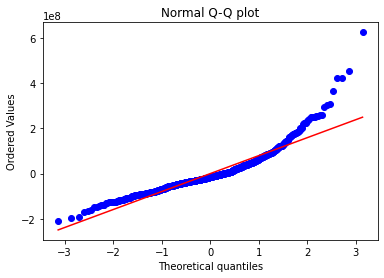

In [10]:
#from scipy import stats
import matplotlib.pyplot as plt
predict=final_fit.predict(x)
resid=y-predict
# diagnose/inspect residual normality using qqplot:
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

Text(0.5, 1.0, 'Residuals vs. Predictions')

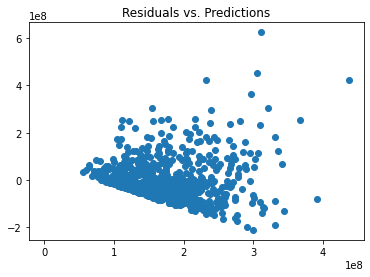

In [14]:
# Plot Residuals vs. predicted
plt.scatter(predict, resid)
plt.plot([0,40], [0, 0])
plt.title("Residuals vs. Predictions")

In [ ]:
# Fitted vs. Actual
y_train_pred = lin_reg_est.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 400], [0, 400])